## Imports and Inputs

In [2]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
# import seaborn as sns
from datetime import datetime, timedelta, timezone

from dune_client.client import DuneClient
from config import key

/tmp/ipykernel_640/2591426926.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# import json of covers from dune api 
dune = DuneClient(key)
covers_list_result = dune.get_latest_result_dataframe(2303588)

In [37]:
# coingecko ETH Market Chart API for ETH-USD for last year
url = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart'
eth_price_params = {'vs_currency': 'usd', 
                   'days': '365',
                   'interval': 'daily'}
eth_usd_prices = requests.get(url, params=eth_price_params).json()['prices']

# create a dataframe with an index of dates and the corresponding ETH prices
price_df = pd.DataFrame(eth_usd_prices, columns = ['Date', 'EthUsd'])
price_df['Date'] = pd.to_datetime(price_df['Date'], utc=True, unit='ms', origin='unix')
price_df.set_index('Date', inplace=True)

## Covers Table Processing

In [75]:
# process covers dataframe and select only current and 11 previous months 
df_covers = covers_list_result

# change timestamp to datetime format and normalise all dates to midnight
df_covers['cover_start_time'] = pd.to_datetime(df_covers['cover_start_time']).dt.floor('D')

# add ETHUSD prices daily
df_covers = df_covers.join(price_df, on='cover_start_time')

# add premium cost in ETH, dividing dollar prices by the ETH value
df_covers['premium_eth'] = df_covers['premium_dollar'] / df_covers['EthUsd']

# cut off from 11 months from start of current month
month = datetime.now().month
year = datetime.now().year
df_covers_sold_last_year = df_covers[df_covers['cover_start_time'] >= datetime(year-1, month+1, 1, tzinfo=timezone.utc)]

# create month and quarter columns
df_covers_sold_last_year['cover_start_month'] = df_covers_sold_last_year['cover_start_time'].dt.to_period('M')
df_covers_sold_last_year['cover_start_quarter'] = df_covers_sold_last_year['cover_start_time'].dt.to_period('Q')

## Monthly Premiums

### USD

cover_start_month
2023-05    117050.226009
2023-06     98451.461209
2023-07     88975.500422
2023-08     53305.803939
2023-09     47161.569566
2023-10     63041.192532
2023-11     73194.145246
2023-12     45677.816811
2024-01     58925.241274
2024-02     90801.694768
2024-03    308375.800319
2024-04    393388.598144
Freq: M, Name: premium_dollar, dtype: float64

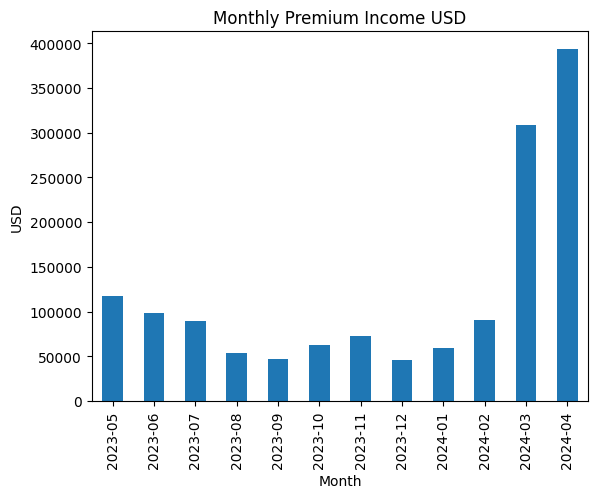

In [76]:
monthly_cover_fees_usd = df_covers_sold_last_year.groupby(by='cover_start_month')['premium_dollar'].sum()
display(monthly_cover_fees_usd)
monthly_cover_fees_usd.plot(kind='bar', ylabel='USD', xlabel='Month', title='Monthly Premium Income USD');

### ETH

cover_start_month
2023-05     63.549741
2023-06     55.703824
2023-07     46.810058
2023-08     30.451598
2023-09     28.957952
2023-10     38.458809
2023-11     38.417020
2023-12     20.055998
2024-01     25.400237
2024-02     35.012024
2024-03     86.737514
2024-04    114.269465
Freq: M, Name: premium_eth, dtype: float64

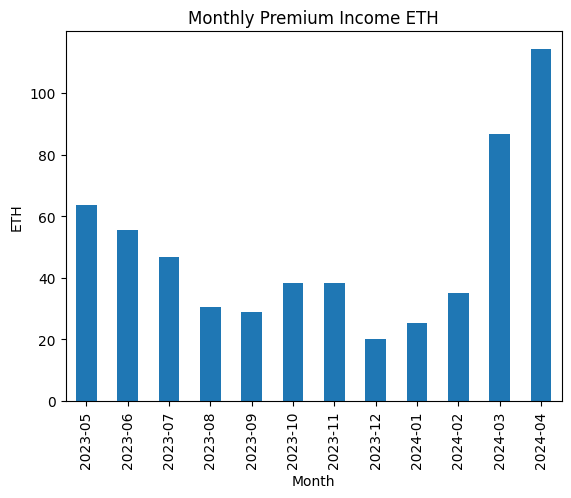

In [77]:
monthly_cover_fees_eth = df_covers_sold_last_year.groupby(by='cover_start_month')['premium_eth'].sum()
display(monthly_cover_fees_eth)
monthly_cover_fees_eth.plot(kind='bar', ylabel='ETH', xlabel='Month', title='Monthly Premium Income ETH');

## Quarterly Premiums

cover_start_quarter
2023Q2    215501.687218
2023Q3    189442.873928
2023Q4    181913.154589
2024Q1    458102.736361
2024Q2    393388.598144
Freq: Q-DEC, Name: premium_dollar, dtype: float64

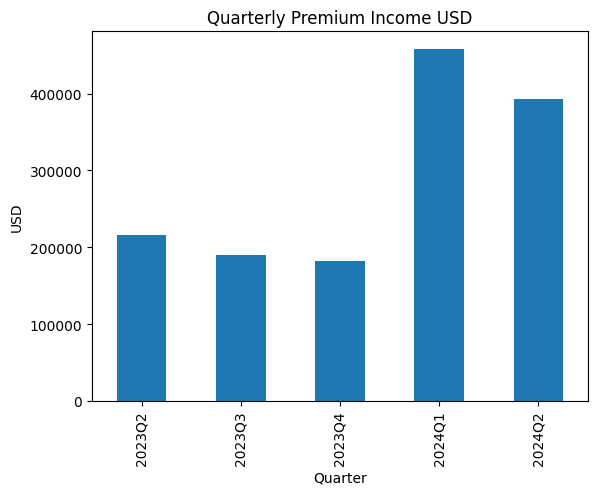

In [79]:
quarterly_cover_fees_usd = df_covers_sold_last_year.groupby(by='cover_start_quarter')['premium_dollar'].sum()
display(quarterly_cover_fees_usd)
quarterly_cover_fees_usd.plot(kind='bar', ylabel='USD', xlabel='Quarter', title='Quarterly Premium Income USD');

In [14]:
# work out cover fees denominated in ETH, allowing for 15% commission
commission_share = 0.15

monthly_cover_fees_usd = df_covers_30_days['premium_dollar'].sum()
monthly_cover_fees_after_commission = monthly_cover_fees_usd * (1 - commission_share)
monthly_commission = monthly_cover_fees_usd * commission_share

monthly_cover_fees_eth = monthly_cover_fees_usd / eth_usd
monthly_cover_fees_eth

39.58797846624159